## 三方库导入

In [1]:
import tensorflow as tf
import numpy as np
import itertools
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import matplotlib.dates as dates
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import optimizers
import time
from functools import reduce
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
#使用RandomUnderSampler进行欠抽样处理
from imblearn.under_sampling import RandomUnderSampler #欠抽样处理库RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

## 数据读取及合并

In [2]:
import_data=pd.read_csv("import_data.csv").drop(['Unnamed: 0'],axis=1)
export_data=pd.read_csv("export_data.csv").drop(['Unnamed: 0'],axis=1)
target=pd.read_csv("Target.csv").drop(['Unnamed: 0'],axis=1)

import_data.rename(columns={'imp_Product5_6_cnt_t':'imp_Product5_6_Trans_cnt_t'},inplace=True)
for i in {1,2,7}:
    import_data.loc[(import_data[f'imp_Product{i}_Trans_amt_t'] != 0) & (import_data[f'imp_Product{i}_Trans_cnt_t'] == 0),f'imp_Product{i}_Trans_cnt_t'] = 1
import_data.loc[(((import_data['imp_Product3_Trans_amt_t'] != 0) | (import_data['imp_Product4_Trans_amt_t'] != 0)) &(import_data['imp_Product3_4_Trans_cnt_t'] == 0)),'imp_Product3_4_Trans_cnt_t'] = 1
import_data.loc[(((import_data['imp_Product5_Trans_amt_t'] != 0) | (import_data['imp_Product6_Trans_amt_t'] != 0)) &(import_data['imp_Product5_6_Trans_cnt_t'] == 0)),'imp_Product5_6_Trans_cnt_t'] = 1

for i in {1,2,3,4,5}:
    export_data.loc[(export_data[f'ex_Product{i}_Trans_amt_t'] != 0) & (export_data[f'ex_Product{i}_Trans_cnt_t'] == 0),f'ex_Product{i}_Trans_cnt_t'] = 1


# import_data['imp_Trans_amt'] = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_imp].sum(axis=1)
# import_data['imp_Trans_count'] = import_data[columns_to_count_imp].sum(axis=1)
# export_data['exp_Trans_amt'] = export_data[columns_to_sum_exp].sum(axis=1)
# export_data['exp_Trans_count'] = export_data[columns_to_count_exp].sum(axis=1)

In [3]:
data=pd.merge(import_data,export_data,how='outer',on=['COHORT_MONTH','COMPANY_ID','IMAGE_DT'])
data=pd.merge(data,target,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()
data['COHORT_MONTH'] = pd.to_datetime(data['COHORT_MONTH'])
data['IMAGE_DT'] = pd.to_datetime(data['IMAGE_DT'])
data.iloc[:, 4:] = data.iloc[:, 4:].clip(lower=0)
data=data.sort_values(['COMPANY_ID','IMAGE_DT'])
data.head()

,COHORT_MONTH,COMPANY_ID,IMAGE_DT,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,...,ex_Product2_Trans_amt_t,ex_Product3_Trans_amt_t,ex_Product4_Trans_amt_t,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,credit_event
24,2020-06-30,4,2019-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,198.639649,0.0,0.0,0.0,0.0,1.0,0.0,0.0
25,2020-06-30,4,2019-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,2020-06-30,4,2019-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,2020-06-30,4,2019-10-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,2020-06-30,4,2019-11-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# dlist=list(data.columns)
# dlist.remove('COHORT_MONTH')
# dlist.remove('COMPANY_ID')
# dlist.remove('IMAGE_DT')
# #dlist.remove('credit_event')

# data_all=data.groupby(['COMPANY_ID','COHORT_MONTH'])[dlist].max().reset_index(drop=False)
# data=data_all.copy()

In [4]:
data['IMAGE_DT_month'] = data['IMAGE_DT'].dt.month
def custom_return(a):
    if 6 <= a <= 12:
        return 18 - a
    else:
        return 6 - a
data['result'] = data['IMAGE_DT_month'].apply(custom_return)
def ewm_zyy(group):
    a = 0.1
    image_dt_months = group['result']
    weights = np.power(1 - a, image_dt_months - 1)

    numeric_columns = group.select_dtypes(include=[np.number]).columns
    weighted_data = group[numeric_columns].mul(weights, axis=0)
    
    # 计算权重加权和
    weighted_sum = weighted_data.sum(axis=0)
    return weighted_sum

In [5]:
grouped_data = data.groupby(['COMPANY_ID', 'COHORT_MONTH'])
weighted_sums = grouped_data.apply(ewm_zyy)
weighted_sums.drop(columns = 'COMPANY_ID', inplace = True)
weighted_sums.drop(columns = 'IMAGE_DT_month', inplace = True)
weighted_sums.drop(columns = 'result', inplace = True)
weighted_sums['credit_event'] = weighted_sums['credit_event'].ne(0).astype(int)
data = weighted_sums.reset_index()
data.head()

C:\Users\Allwings\AppData\Local\Temp\ipykernel_41176\1843960184.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_sums = grouped_data.apply(ewm_zyy)


,COMPANY_ID,COHORT_MONTH,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,...,ex_Product2_Trans_amt_t,ex_Product3_Trans_amt_t,ex_Product4_Trans_amt_t,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,credit_event
0,4,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,69.261363,0.0,0.0,0.0,0.0,0.348678,0.0,0
1,4,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,12,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,12,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,12,2022-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0


In [6]:
#merge data with new features
columns_to_sum_imp = [f'imp_Product{i}_Trans_amt_t' for i in range(1,8)]
columns_to_count_imp = [f'imp_Product{i}_Trans_cnt_t' for i in ['1','2','3_4','5_6','7']]
columns_to_sum_exp = [f'ex_Product{i}_Trans_amt_t' for i in range(1,6)]
columns_to_count_exp = [f'ex_Product{i}_Trans_cnt_t' for i in range(1,6)]

import_amount_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_imp].sum().sum(axis=1).reset_index().rename(columns = {0:'imp_Trans_amt'})
import_count_df = import_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_imp].sum().sum(axis=1).reset_index().rename(columns = {0:'imp_Trans_count'})
import_total_feature = pd.merge(import_amount_df,import_count_df,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# import_data = pd.merge(import_data,import_total_feature,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()

export_amount_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_sum_exp].sum().sum(axis=1).reset_index().rename(columns = {0:'exp_Trans_amt'})
export_count_df = export_data.groupby(['COMPANY_ID','COHORT_MONTH'])[columns_to_count_exp].sum().sum(axis=1).reset_index().rename(columns = {0:'exp_Trans_count'})
export_total_feature = pd.merge(export_amount_df,export_count_df,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
# export_data = pd.merge(export_data,export_total_feature,how='left',on=['COHORT_MONTH','COMPANY_ID']).dropna()

data_total_feature = pd.merge(import_total_feature,export_total_feature,how='outer',on=['COHORT_MONTH','COMPANY_ID']).dropna()
data_total_feature['COHORT_MONTH'] = pd.to_datetime(data_total_feature['COHORT_MONTH'])
data = pd.merge(data,data_total_feature,how='left',on=['COMPANY_ID','COHORT_MONTH']).dropna()
data.head()

,COMPANY_ID,COHORT_MONTH,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,...,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,credit_event,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count
0,4,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.348678,0.0,0,0.0,0.0,198.639649,1.0
1,4,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.000000,0.0
2,12,2020-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.000000,0.0
3,12,2021-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.000000,0.0
4,12,2022-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0,0.0,0.0,0.000000,0.0


In [7]:
columns = list(data.columns)
columns.remove('credit_event')
columns.append('credit_event')
data_new = data[columns]
data_new.head()
data = data_new.copy()

In [9]:
# dlist=list(data.columns)
# dlist.remove('COHORT_MONTH')
# dlist.remove('COMPANY_ID')
# dlist.remove('IMAGE_DT')
# dlist.remove('credit_event')
# data_all=pd.DataFrame()
# for i in list(data['COMPANY_ID'].unique()):
#     test=data[data['COMPANY_ID']==i].copy()
#     test[dlist]=test[dlist].ewm(span=30).mean()
#     data_all=pd.concat([data_all,test],axis=0)
# data=data_all.copy()

## 数据处理前描述性统计

In [8]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
COMPANY_ID,12866.0,10990.010804,4.0,5411.0,12198.0,16714.0,18727.0,5936.872996
COHORT_MONTH,12866,2021-07-07 20:35:57.873465088,2020-06-30 00:00:00,2020-06-30 00:00:00,2021-06-30 00:00:00,2022-06-30 00:00:00,2022-06-30 00:00:00,NaN
imp_Product1_Trans_amt_t,12866.0,19.432832,0.0,0.0,0.0,0.0,12258.665479,320.03741
imp_Product2_Trans_amt_t,12866.0,356.376861,0.0,0.0,0.0,0.0,105473.343453,2932.190782
imp_Product3_Trans_amt_t,12866.0,20.161548,0.0,0.0,0.0,0.0,31950.897738,405.933727
imp_Product4_Trans_amt_t,12866.0,368.959242,0.0,0.0,0.0,0.0,104422.126623,2949.952603
imp_Product5_Trans_amt_t,12866.0,104.245473,0.0,0.0,0.0,0.0,30457.785204,771.053257
imp_Product6_Trans_amt_t,12866.0,416.147473,0.0,0.0,0.0,0.0,109599.389092,2473.46922
imp_Product7_Trans_amt_t,12866.0,192.685509,0.0,0.0,0.0,0.0,61193.07157,1358.269815
imp_Product1_Trans_cnt_t,12866.0,0.017332,0.0,0.0,0.0,0.0,12.138108,0.287675


# 3. Randomly select training samples (70%) and test samples (30%).

In [15]:
train, test = train_test_split(data,test_size = 0.3,random_state = 42,stratify = data['credit_event'])

In [10]:
# X, y = data.iloc[:, 2:], data['credit_event']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [18]:
stdlist = list(train.columns)
stdlist.remove('credit_event')
stdlist.remove('COHORT_MONTH')
stdlist.remove('COMPANY_ID')
train[stdlist]

,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,imp_Product2_Trans_cnt_t,imp_Product3_4_Trans_cnt_t,...,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count
2279,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
9849,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.656100,0.0,0.000000,0.0,1636.995819,1.0
8470,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
374,0.0,1287.52883,488.69824,259.792935,0.0,0.0,0.0,0.0,2.176304,0.908764,...,0.0,0.0,0.0,0.0,0.000000,0.0,10459.848184,16.0,0.000000,0.0
3980,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3288,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1751,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2.508146,0.0,0.000000,0.0,3558.196265,4.0
10170,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
4091,0.0,0.00000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [19]:
stdsc = StandardScaler()
train[stdlist] = stdsc.fit_transform(train[stdlist])
test[stdlist] = stdsc.fit_transform(test[stdlist])

# xtrainlist = list(X_train.columns)
# X_train[xtrainlist]=stdsc.fit_transform(X_train[xtrainlist])
# xtestlist = list(X_test.columns)
# X_test[xtestlist]=stdsc.fit_transform(X_test[xtestlist])

ros = RandomOverSampler()
X_res, y_new2 = ros.fit_resample(train[stdlist], train['credit_event'])
display(X_res)
display(y_new2)

,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,imp_Product2_Trans_cnt_t,imp_Product3_4_Trans_cnt_t,...,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count
0,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
1,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.122643,-0.122218,-0.212817,-0.205542,-0.156125,-0.200960
2,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
3,-0.058776,0.335726,0.989378,-0.031642,-0.137442,-0.160764,-0.138616,-0.059838,1.838560,0.295868,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,0.655239,1.198944,-0.320764,-0.276351
4,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17833,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
17834,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
17835,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
17836,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351


0        0
1        0
2        0
3        0
4        0
        ..
17833    1
17834    1
17835    1
17836    1
17837    1
Name: credit_event, Length: 17838, dtype: int32

In [14]:
""" dlist = list(data.columns)
dwlist = dlist.copy()
dwlist.remove('COHORT_MONTH')
dwlist.remove('COMPANY_ID')
dwlist.remove('credit_event')
transfer = StandardScaler()
data[dwlist] = transfer.fit_transform(data[dwlist])
x=data[dlist]
y=data['credit_event']
rus = RandomUnderSampler()
X_res, y_new2 = rus.fit_resample(x, y)
display(X_res)
display(y_new2)
# X_res.groupby(['credit_event']).size() """

" dlist = list(data.columns)\ndwlist = dlist.copy()\ndwlist.remove('COHORT_MONTH')\ndwlist.remove('COMPANY_ID')\ndwlist.remove('credit_event')\ntransfer = StandardScaler()\ndata[dwlist] = transfer.fit_transform(data[dwlist])\nx=data[dlist]\ny=data['credit_event']\nrus = RandomUnderSampler()\nX_res, y_new2 = rus.fit_resample(x, y)\ndisplay(X_res)\ndisplay(y_new2)\n# X_res.groupby(['credit_event']).size() "

In [20]:
# stdsc = StandardScaler()
# X_train_std = stdsc.fit_transform(X_train)
# X_test_std = stdsc.transform(X_test)
# display(X_train_std)
# display(X_test_std)
# display(y_train)
# display(y_test)

In [21]:
# #oversampling
# dlist=list(data.columns)
# dlist.remove('COHORT_MONTH')
# dlist.remove('COMPANY_ID')
# #dlist.remove('IMAGE_DT')
# x=data[dlist]
# y=data['credit_event']

# rus = RandomUnderSampler()
# X_res, y_new2 = rus.fit_resample(X_train_std, y_train)
# display(X_res)
# display(y_new2)

In [22]:
# #data['Month_Difference'] = (data['COHORT_MONTH'] - data['IMAGE_DT']).dt.days // 30
# dlist = list(data.columns)
# dwlist = dlist.copy()
# dwlist.remove('COHORT_MONTH')
# dwlist.remove('COMPANY_ID')
# # dwlist.remove('IMAGE_DT')
# dwlist.remove('credit_event')
# transfer = StandardScaler()
# data[dwlist] = transfer.fit_transform(data[dwlist])
# x=data[dlist]
# y=data['credit_event']
# rus = RandomUnderSampler()
# X_res, y_new2 = rus.fit_resample(x, y)
# display(X_res)
# display(y_new2)
# # X_res.groupby(['credit_event']).size()

## 数据欠抽样前后对比

In [23]:
# data.groupby(['credit_event'])['credit_event'].count()

In [30]:
# #undersampling
# dlist=list(data.columns)
# dlist.remove('COHORT_MONTH')
# dlist.remove('COMPANY_ID')
# #dlist.remove('IMAGE_DT')
# x=data[dlist]
# y=data['credit_event']

# rus = RandomUnderSampler()
# X_res, y_new2 = rus.fit_resample(x, y)
# X_res.groupby(['credit_event']).size()

In [24]:
# #oversampling
# dlist=list(data.columns)
# dlist.remove('COHORT_MONTH')
# dlist.remove('COMPANY_ID')
# #dlist.remove('IMAGE_DT')
# x=data[dlist]
# y=data['credit_event']

# smote = SMOTE()
# X_res, y_new2 = smote.fit_resample(x, y)
# X_res.groupby(['credit_event']).size()

## 数据预处理后描述性统计

In [25]:
X_res.describe().T

,count,mean,std,min,25%,50%,75%,max
imp_Product1_Trans_amt_t,17838.0,-0.029101,0.711174,-0.058776,-0.058776,-0.058776,-0.058776,39.819165
imp_Product2_Trans_amt_t,17838.0,-0.025058,0.796301,-0.119499,-0.119499,-0.119499,-0.119499,37.172192
imp_Product3_Trans_amt_t,17838.0,-0.007947,0.742342,-0.047529,-0.047529,-0.047529,-0.047529,67.745010
imp_Product4_Trans_amt_t,17838.0,-0.029189,0.803891,-0.126550,-0.126550,-0.126550,-0.126550,38.020959
imp_Product5_Trans_amt_t,17838.0,0.172739,1.667194,-0.137442,-0.137442,-0.137442,-0.137442,27.628754
imp_Product6_Trans_amt_t,17838.0,0.067142,1.000705,-0.160764,-0.160764,-0.160764,-0.160764,42.353034
imp_Product7_Trans_amt_t,17838.0,0.183859,1.548330,-0.138616,-0.138616,-0.138616,-0.138616,43.290912
imp_Product1_Trans_cnt_t,17838.0,-0.029627,0.711197,-0.059838,-0.059838,-0.059838,-0.059838,46.743011
imp_Product2_Trans_cnt_t,17838.0,-0.035197,0.860797,-0.165462,-0.165462,-0.165462,-0.165462,33.526934
imp_Product3_4_Trans_cnt_t,17838.0,-0.011612,0.928924,-0.129800,-0.129800,-0.129800,-0.129800,46.284048


## 数据相关性分析

In [26]:
X_res[stdlist].corr()

,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,imp_Product2_Trans_cnt_t,imp_Product3_4_Trans_cnt_t,...,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count
imp_Product1_Trans_amt_t,1.000000,0.027424,0.209192,0.099925,-0.000456,0.001075,0.045082,0.905612,0.067806,0.147208,...,0.031211,0.091142,-0.001104,0.022837,0.016868,0.020270,0.084803,0.095928,0.032675,0.037902
imp_Product2_Trans_amt_t,0.027424,1.000000,0.296883,0.982094,0.239203,0.232003,0.299951,0.032839,0.823301,0.751981,...,0.096599,0.012363,0.010943,0.096860,0.072947,0.029112,0.750003,0.516847,0.245379,0.075312
imp_Product3_Trans_amt_t,0.209192,0.296883,1.000000,0.240615,-0.001665,0.010000,0.018664,0.198068,0.215195,0.184770,...,0.004132,0.009620,-0.001410,0.038047,0.009202,0.003758,0.222434,0.111336,0.019932,0.011629
imp_Product4_Trans_amt_t,0.099925,0.982094,0.240615,1.000000,0.252637,0.243983,0.320564,0.095672,0.815809,0.778291,...,0.107538,0.016256,0.004788,0.107153,0.078889,0.038209,0.761744,0.538964,0.255468,0.083554
imp_Product5_Trans_amt_t,-0.000456,0.239203,-0.001665,0.252637,1.000000,0.634067,0.767117,0.003957,0.301825,0.357907,...,0.007615,0.104214,-0.004781,0.055045,0.038985,0.011535,0.716799,0.699252,0.059558,0.062524
imp_Product6_Trans_amt_t,0.001075,0.232003,0.010000,0.243983,0.634067,1.000000,0.623002,0.005013,0.296675,0.322814,...,0.109156,0.196035,0.025532,0.237128,0.127716,0.106173,0.720830,0.700335,0.351144,0.196528
imp_Product7_Trans_amt_t,0.045082,0.299951,0.018664,0.320564,0.767117,0.623002,1.000000,0.047284,0.373474,0.443916,...,0.053690,0.156149,-0.005399,0.072393,0.001244,0.067527,0.773599,0.775824,0.077733,0.063564
imp_Product1_Trans_cnt_t,0.905612,0.032839,0.198068,0.095672,0.003957,0.005013,0.047284,1.000000,0.086896,0.157053,...,0.022615,0.146132,-0.001124,0.023236,0.013307,0.016117,0.085264,0.109355,0.031648,0.046721
imp_Product2_Trans_cnt_t,0.067806,0.823301,0.215195,0.815809,0.301825,0.296675,0.373474,0.086896,1.000000,0.889220,...,0.065744,0.064114,0.033740,0.096554,0.097870,0.023423,0.710473,0.651014,0.177322,0.105560
imp_Product3_4_Trans_cnt_t,0.147208,0.751981,0.184770,0.778291,0.357907,0.322814,0.443916,0.157053,0.889220,1.000000,...,0.058670,0.029014,0.009166,0.066931,0.063103,0.021786,0.714954,0.701787,0.114398,0.066510


## 相关性热力图

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, fill_value='mean', correlation_type='pearson', figsize=(20,20)):
    """
    绘制 DataFrame 的相关性矩阵热图。

    参数:
    - df (pandas.DataFrame): 包含数据的 DataFrame。
    - fill_value (str or float): 用于填充缺失值的策略，可以是 'mean'、'median' 或具体的数值。
    - correlation_type (str): 计算相关系数的类型，可选 'pearson'、'spearman'、'kendall'。

    返回:
    - None，但会显示热图。
    """
    # 处理缺失值
    if isinstance(fill_value, str):
        if fill_value == 'mean':
            df = df.fillna(df.mean())
        elif fill_value == 'median':
            df = df.fillna(df.median())
        else:
            raise ValueError("fill_value must be 'mean', 'median', or a numerical value.")
    else:
        df = df.fillna(fill_value)
    
    # 计算相关性矩阵
    corr_matrix = df.corr(method=correlation_type)
    
    # 绘制热图
    plt.figure(figsize=(20,20))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

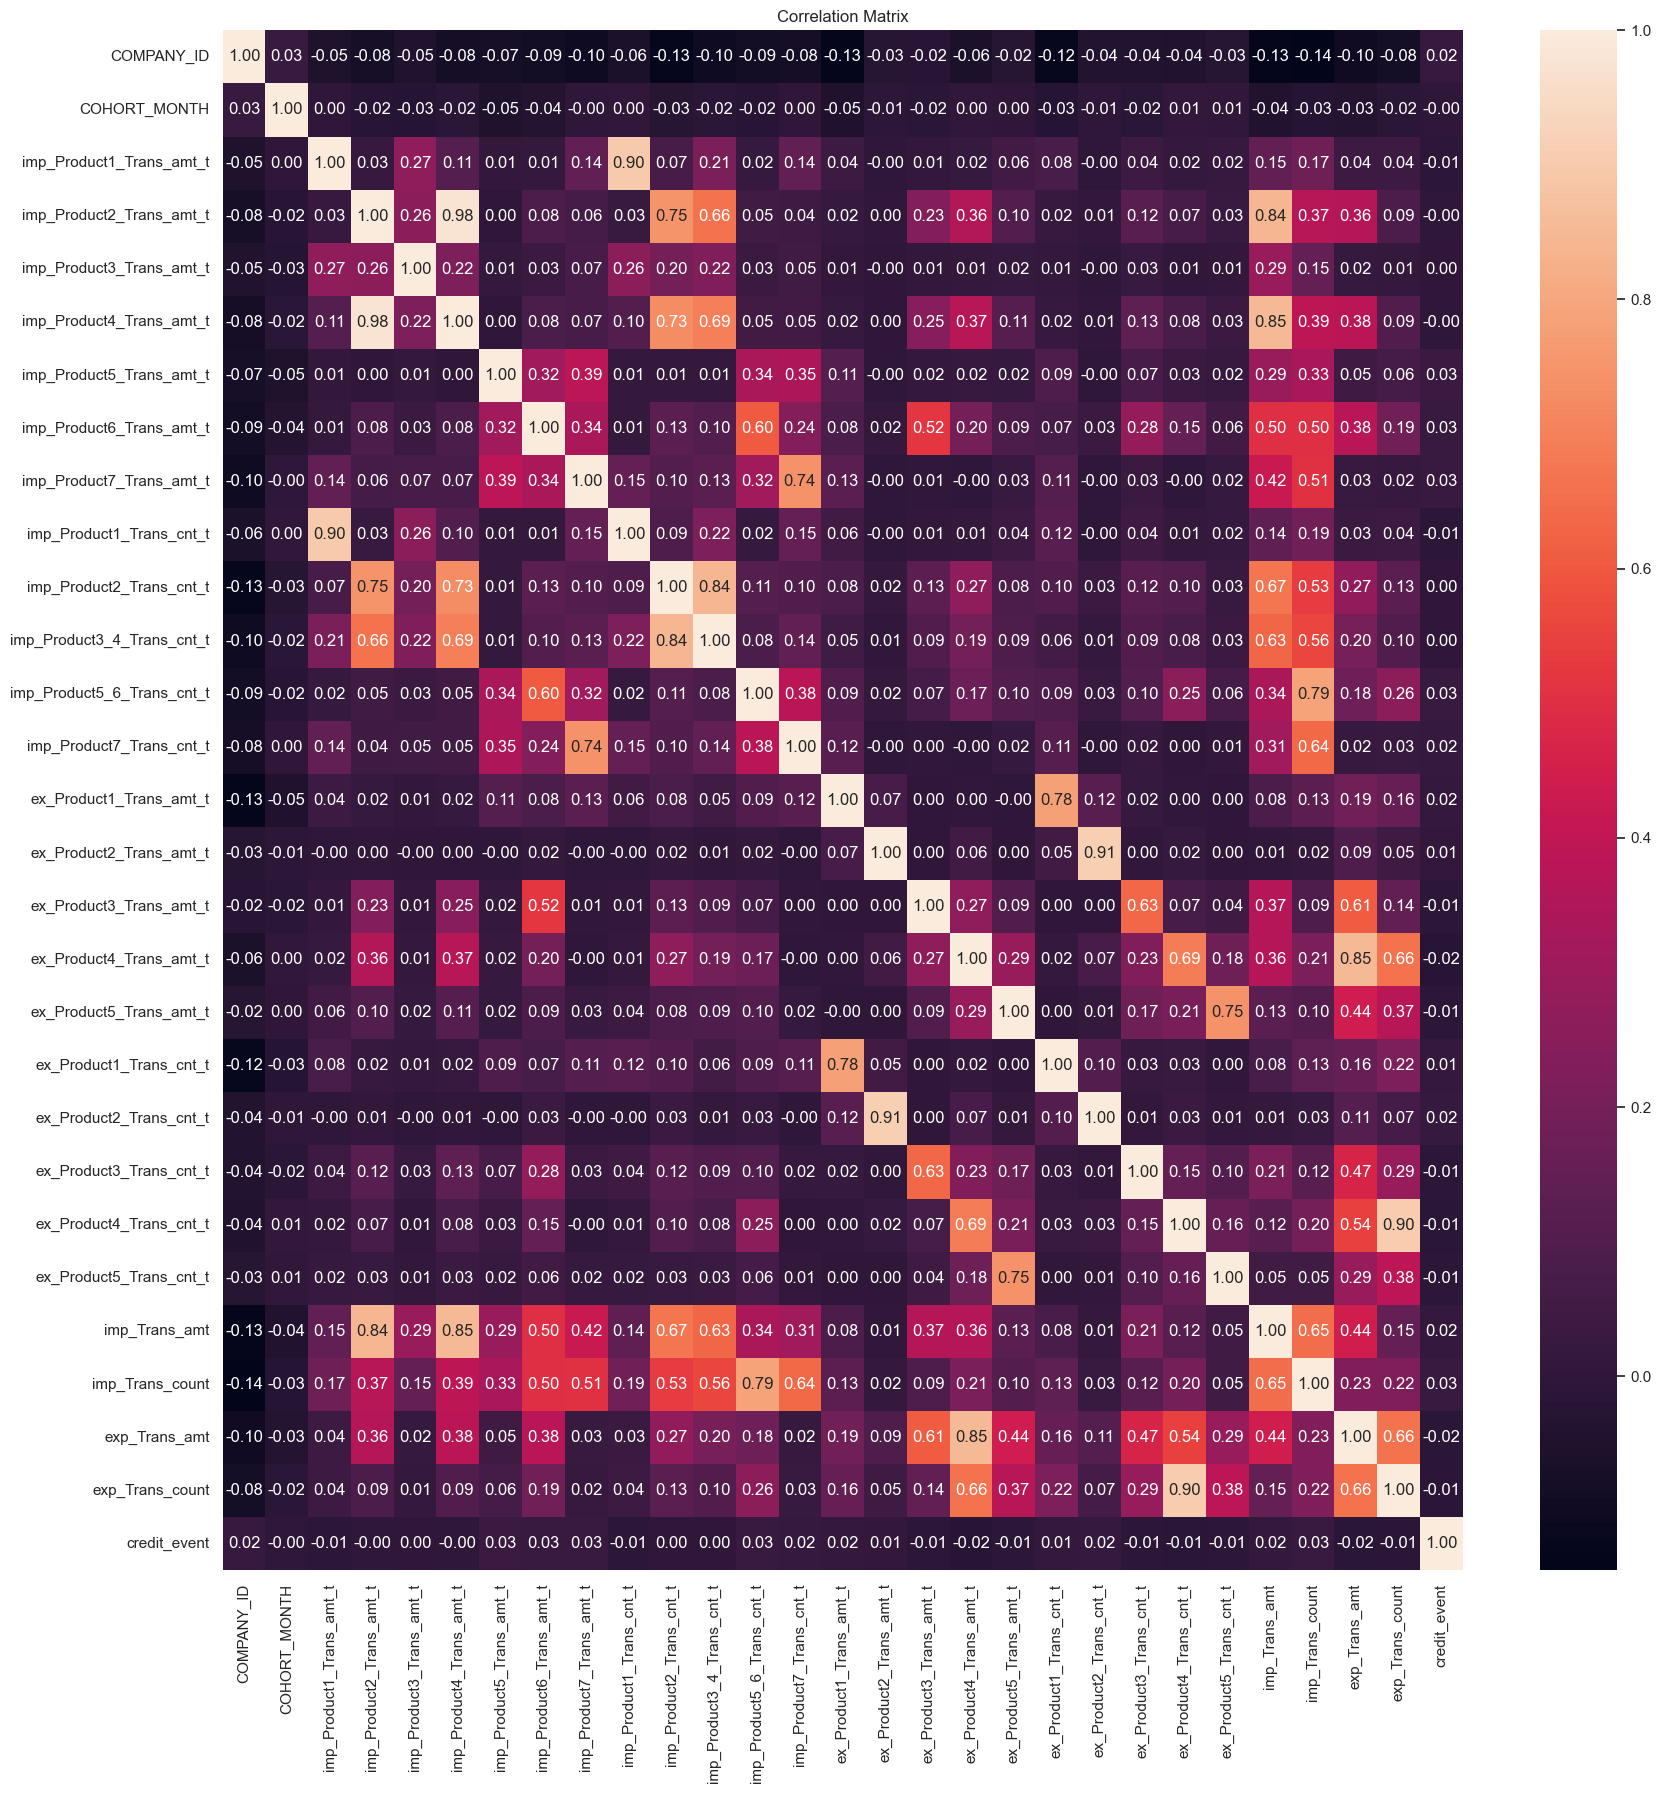

In [53]:
plot_correlation_matrix(data)

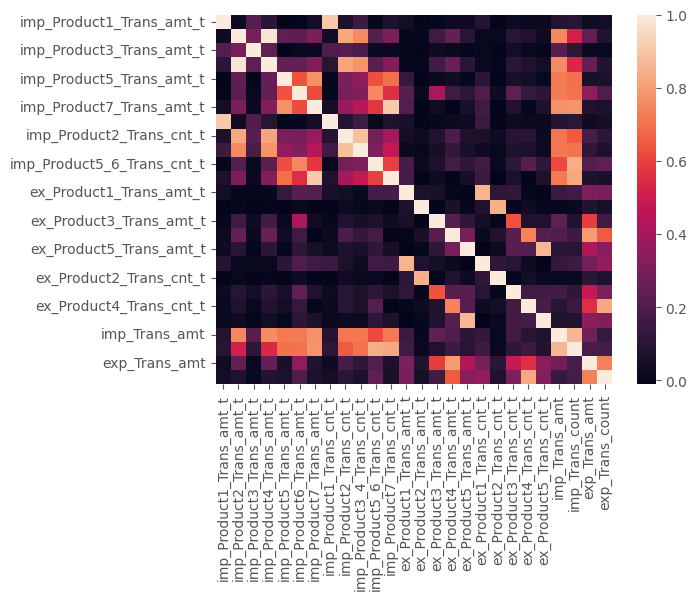

In [27]:
uniform_data = np.random.rand(16, 20)
sns.heatmap(X_res[stdlist].corr())
plt.show()

## 随机森林特征选择

In [28]:
X_res

,imp_Product1_Trans_amt_t,imp_Product2_Trans_amt_t,imp_Product3_Trans_amt_t,imp_Product4_Trans_amt_t,imp_Product5_Trans_amt_t,imp_Product6_Trans_amt_t,imp_Product7_Trans_amt_t,imp_Product1_Trans_cnt_t,imp_Product2_Trans_cnt_t,imp_Product3_4_Trans_cnt_t,...,ex_Product5_Trans_amt_t,ex_Product1_Trans_cnt_t,ex_Product2_Trans_cnt_t,ex_Product3_Trans_cnt_t,ex_Product4_Trans_cnt_t,ex_Product5_Trans_cnt_t,imp_Trans_amt,imp_Trans_count,exp_Trans_amt,exp_Trans_count
0,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
1,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.122643,-0.122218,-0.212817,-0.205542,-0.156125,-0.200960
2,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
3,-0.058776,0.335726,0.989378,-0.031642,-0.137442,-0.160764,-0.138616,-0.059838,1.838560,0.295868,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,0.655239,1.198944,-0.320764,-0.276351
4,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17833,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
17834,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
17835,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351
17836,-0.058776,-0.119499,-0.047529,-0.126550,-0.137442,-0.160764,-0.138616,-0.059838,-0.165462,-0.129800,...,-0.128621,-0.118518,-0.037235,-0.118018,-0.217995,-0.122218,-0.212817,-0.205542,-0.320764,-0.276351


In [37]:
# ddst=list(X_res.columns)
# ddst.remove('credit_event')
clf = RandomForestClassifier()
clf.fit(X_res[stdlist],y_new2)
feat_importances = pd.Series(clf.feature_importances_, index=stdlist).to_frame().reset_index(drop=False).rename(columns={0:'Feature_Importances','index':'Feature_Name'}).sort_values(['Feature_Importances'])
feat_importances

,Feature_Name,Feature_Importances
13,ex_Product2_Trans_amt_t,0.000022
18,ex_Product2_Trans_cnt_t,0.000036
7,imp_Product1_Trans_cnt_t,0.000118
0,imp_Product1_Trans_amt_t,0.000341
14,ex_Product3_Trans_amt_t,0.009830
21,ex_Product5_Trans_cnt_t,0.011854
19,ex_Product3_Trans_cnt_t,0.012646
16,ex_Product5_Trans_amt_t,0.013631
9,imp_Product3_4_Trans_cnt_t,0.014367
2,imp_Product3_Trans_amt_t,0.015555


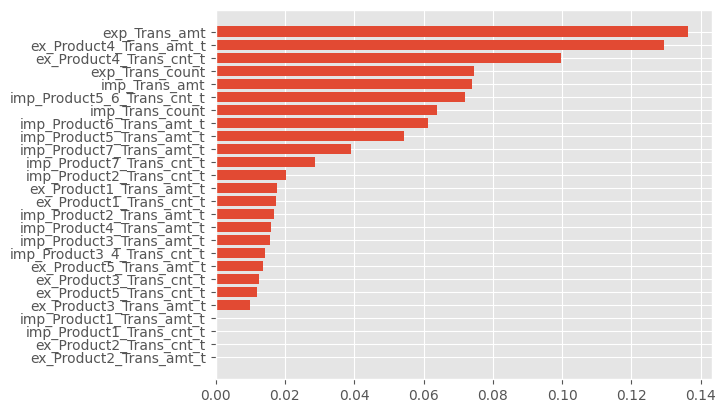

In [38]:
plt.barh(feat_importances.Feature_Name,feat_importances.Feature_Importances)
plt.show()

## 训练集测试集划分

In [39]:
ddt = feat_importances.tail(5)['Feature_Name'].to_list()
# # trainX, testX, trainY, testY = train_test_split(X_res[ddt], X_res['credit_event'], test_size=0.4)
trainX, testX, trainY, testY = X_res[ddt], test[ddt], y_new2, test['credit_event']

## 模型预测评估（基于混淆矩阵）

In [89]:
def met_classi(expected,predicted):
    accuracy = metrics.accuracy_score(expected, predicted)  # accuracy准确率
    Recall = metrics.recall_score(expected, predicted)   # recall 召回率
    Prec = metrics.precision_score(expected, predicted)  #precision 精度
    f1 = metrics.f1_score(expected, predicted) # f1 score f1分数
    mse=metrics.mean_squared_error(expected, predicted)
    con=metrics.confusion_matrix(expected, predicted)
    print("Accuracy: %.3f%%" % (accuracy * 100.0))
    print("Recall: %.3f%%" % (Recall * 100.0))
    print("Prec: %.3f%%" % (Prec * 100.0))
    print("F1: %.3f%%" % (f1 * 100.0))
    print("MSE: %.3f" % (mse))
    print("ConfusionMatrix:\n" ,con)
    sns.set(font_scale=1)
    hm = sns.heatmap(con,
                    annot=True,fmt='.0f',cmap='RdBu')
    plt.title("ConfusionMatrix", fontsize=15)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    precision, recall, _ = precision_recall_curve(expected, predicted)
    ap = average_precision_score(expected, predicted)
    # 绘制PR曲线
    # plt.figure(figsize=(8, 6)) 
    plt.plot(recall, precision,color='darkorange',label='AP={0:0.2f}'.format(ap))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.text(0.8,0.2,'AP={0:0.2f}'.format(ap))
    plt.show()


    # # 计算ROC曲线和AUC值
    # fpr, tpr, _ = roc_curve(expected, predicted)
    # roc_auc = auc(fpr, tpr)
    # # 绘制ROC曲线
    # plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    # plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title('Receiver operating characteristic')
    # plt.legend(loc="lower right")
    # plt.show()
    return
from sklearn.metrics import roc_auc_score, roc_curve
def calculate_auc(y_true, y_score):
    """
    参数：
    - y_true: 真实标签
    - y_score: 预测得分
    """
    auc = roc_auc_score(y_true, y_score)
    return auc

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_score):
    """
    参数：
    - y_true: 真实标签
    - y_score: 预测得分
    """
    # 计算FPR, TPR, 和 thresholds
    fpr, tpr, _ = roc_curve(y_true, y_score)
    # 计算AUC
    auc = roc_auc_score(y_true, y_score)
    
    # 绘制ROC曲线
    plt.figure(figsize=(8, 6))  # 设置图像大小
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    # 添加图标签和标题
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# 使用示例
# plot_roc_curve(y_true, y_score)

## Logistic模型搭建及训练

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# 创建 Logistic 回归模型
model = LogisticRegression()

# 定义评价指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

# 定义超参数搜索空间
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# 使用网格搜索和5折交叉验证进行调参
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

# 获取最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
pre_y = best_model.predict(testX)

Best Parameters: {'C': 1}
Accuracy: 31.218%
Recall: 83.784%
Prec: 1.157%
F1: 2.282%
MSE: 0.688
ConfusionMatrix:
 [[1174 2649]
 [   6   31]]


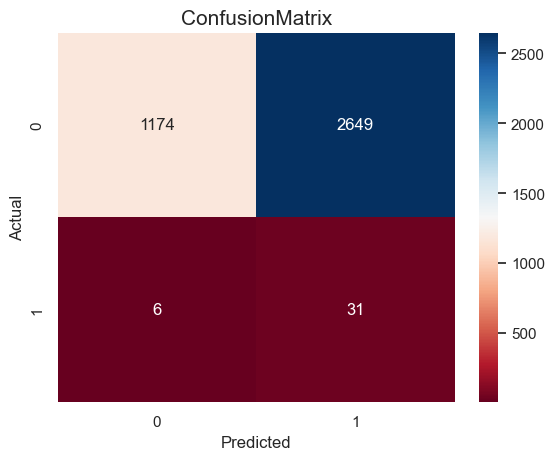

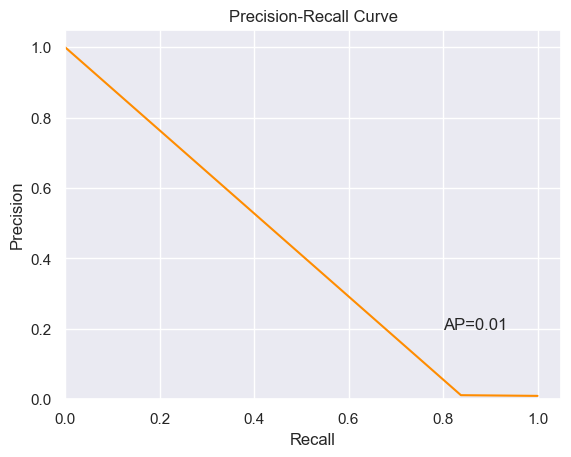

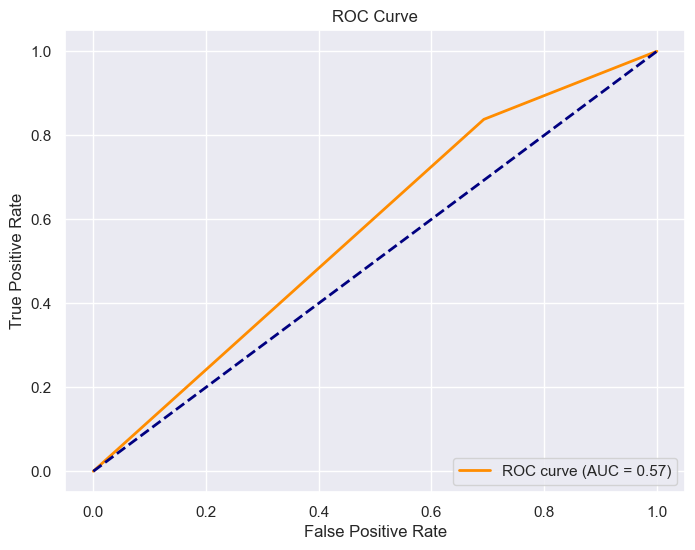

In [91]:
predict_y = np.copy(pre_y)
ymean=np.mean(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,pre_y)
plot_roc_curve(testY,predict_y)

## SVM模型搭建及训练

In [93]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# 创建 SVM 模型
model = SVC(random_state=1)

# 定义评价指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'f1': make_scorer(f1_score)}

# 定义超参数搜索空间
param_grid = {'C': [0.001, 0.01, 0.1],
              'gamma':[0.1,1,10],}

# 使用网格搜索和5折交叉验证进行调参
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

# 获取最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
pre_y = best_model.predict(testX)

Best Parameters: {'C': 0.1, 'gamma': 10}
Accuracy: 38.316%
Recall: 67.568%
Prec: 1.044%
F1: 2.057%
MSE: 0.617
ConfusionMatrix:
 [[1454 2369]
 [  12   25]]


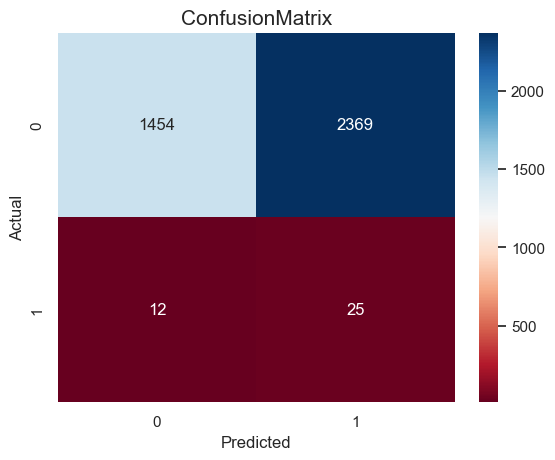

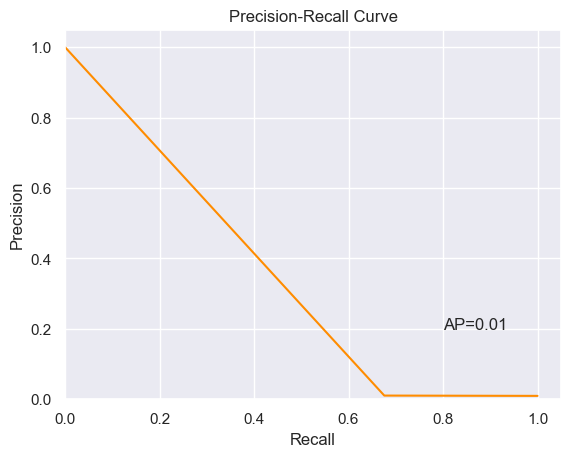

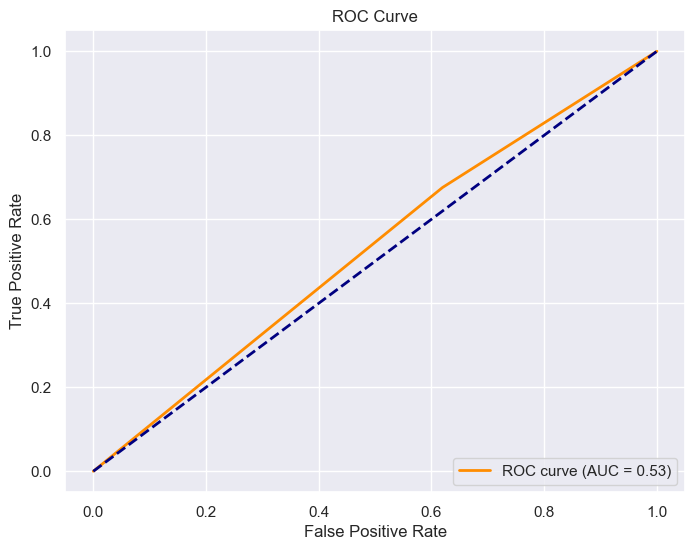

In [94]:
predict_y = np.copy(pre_y)
ymean=np.mean(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,pre_y)
plot_roc_curve(testY,predict_y)

## Decision Tree

In [96]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# 创建决策树分类器模型
model = DecisionTreeClassifier()

# 定义评价指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

# 定义超参数搜索空间
param_grid = {'max_depth': [10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# 使用网格搜索和5折交叉验证进行调参
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

# 获取最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
pre_y = best_model.predict(testX)

Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 43.497%
Recall: 62.162%
Prec: 1.050%
F1: 2.066%
MSE: 0.565
ConfusionMatrix:
 [[1656 2167]
 [  14   23]]


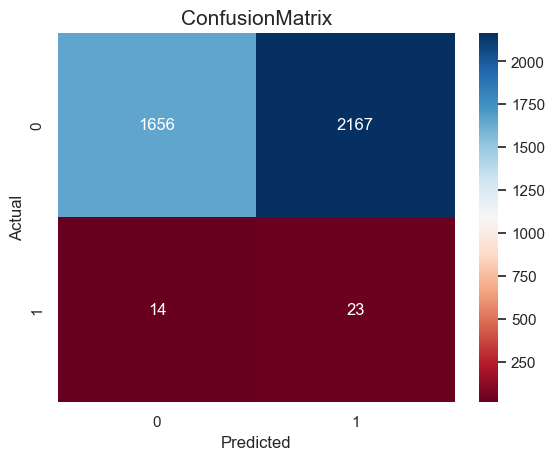

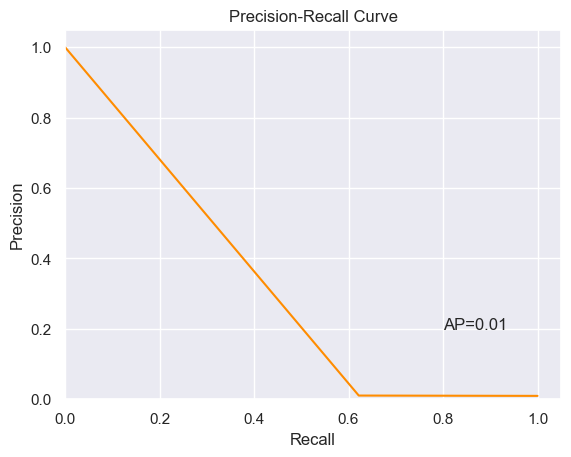

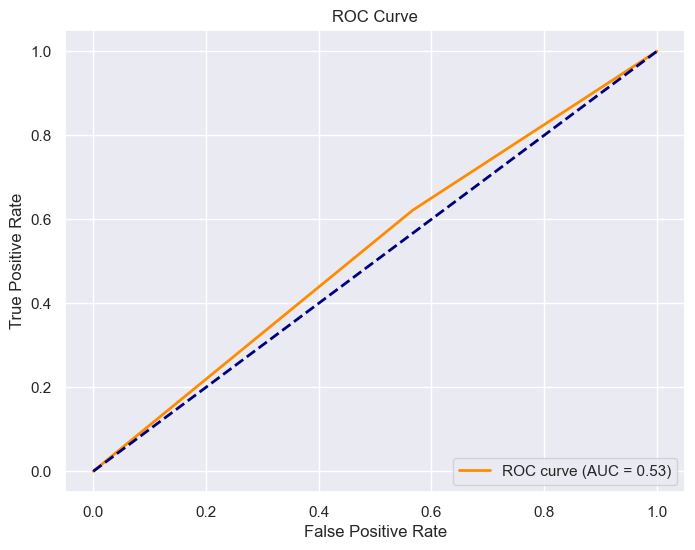

In [97]:
predict_y = np.copy(pre_y)
ymean=np.mean(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,pre_y)
plot_roc_curve(testY,predict_y)

## Random Forest

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# 创建随机森林分类器模型
model = RandomForestClassifier()

# 定义评价指标
scoring = {'accuracy': make_scorer(accuracy_score),
           'recall': make_scorer(recall_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score)}

# 定义超参数搜索空间
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [None, 10, 20, 30, 40, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# 使用网格搜索和5折交叉验证进行调参
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=scoring, refit='recall')
grid_search.fit(trainX, trainY)

# 获取最佳模型
best_model = grid_search.best_estimator_

# 使用最佳模型进行预测
pre_y = best_model.predict(testX)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 43.679%
Recall: 62.162%
Prec: 1.054%
F1: 2.072%
MSE: 0.563
ConfusionMatrix:
 [[1663 2160]
 [  14   23]]


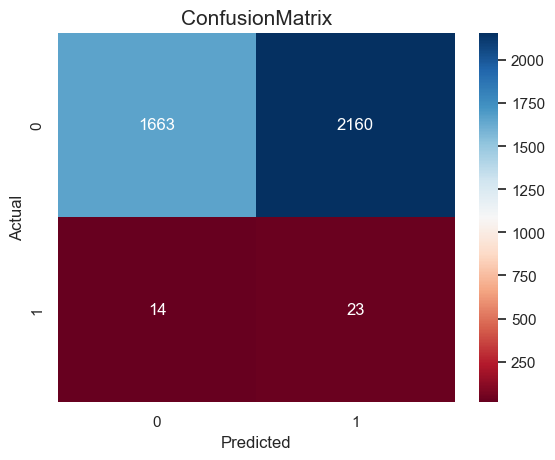

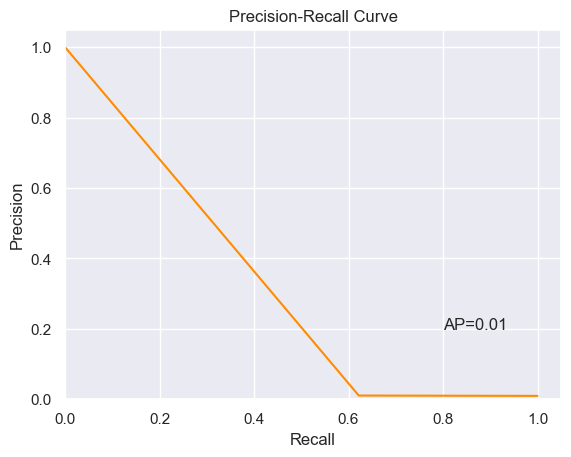

In [99]:
ymean=np.mean(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
print("Best Parameters:", grid_search.best_params_)
met_classi(testY,pre_y)

## LSTM模型搭建及训练

In [46]:
#LSTM模型构建以及训练
model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(input_dim=1, units=50, return_sequences=True),
    tf.keras.layers.LSTM(input_dim=50, units=100, return_sequences=True),
    tf.keras.layers.LSTM(input_dim=100, units=200, return_sequences=True),
    tf.keras.layers.LSTM(300, return_sequences=False),
    tf.keras.layers.Dense(units=100),
    tf.keras.layers.Dense(units=1)
])
model.add(Activation('sigmoid'))    
start = time.time()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(0.01),loss=keras.losses.mean_squared_error)
model_information=model.fit(trainX, trainY, epochs=10, verbose=1)	#模型训练

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, None, 50)          10400     
                                                                 
 lstm_5 (LSTM)               (None, None, 100)         60400     
                                                                 
 lstm_6 (LSTM)               (None, None, 200)         240800    
                                                                 
 lstm_7 (LSTM)               (None, 300)               601200    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
 activation_1 (Activation)   (None, 1)                

## 模型损失可视化

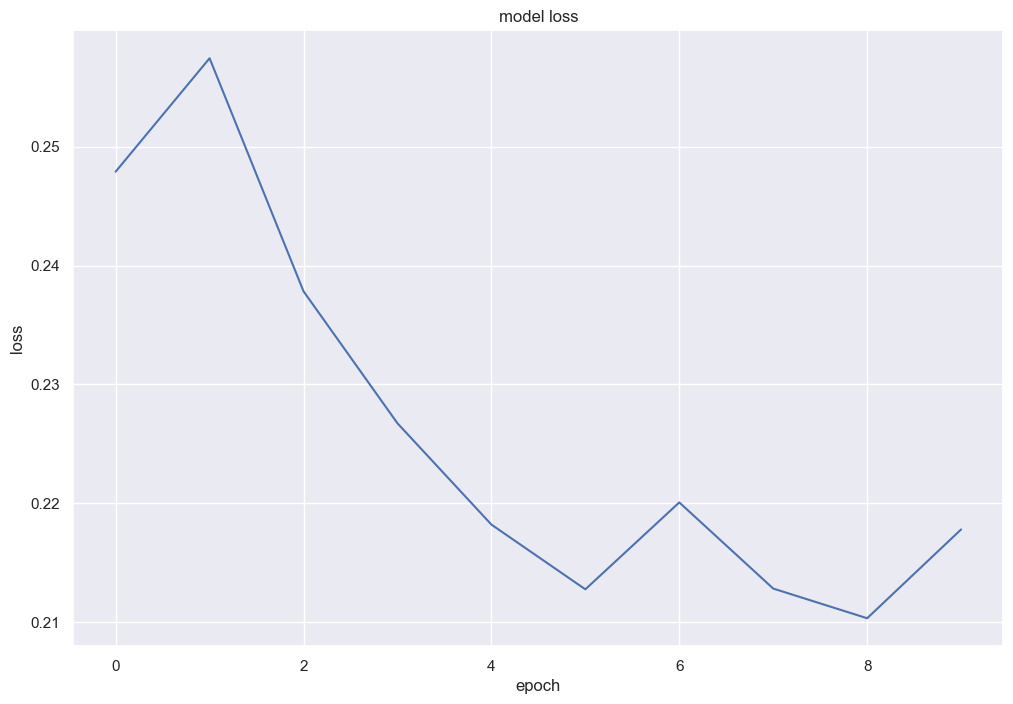

In [54]:
information_loss=model_information.history['loss']  #模型训练损失
def loss(information_loss):
    plt.figure(figsize=(12, 8))
    plt.plot(information_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
loss(information_loss)


121/121 [==============================] - 3s 24ms/step
Accuracy: 38.135%
Recall: 72.973%
Prec: 1.123%
F1: 2.211%
MSE: 0.619
ConfusionMatrix:
 [[1445 2378]
 [  10   27]]


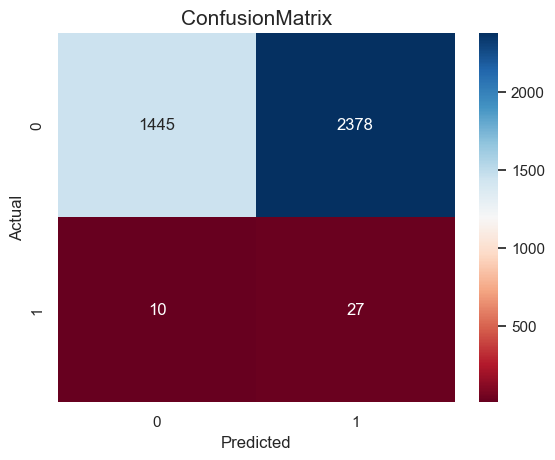

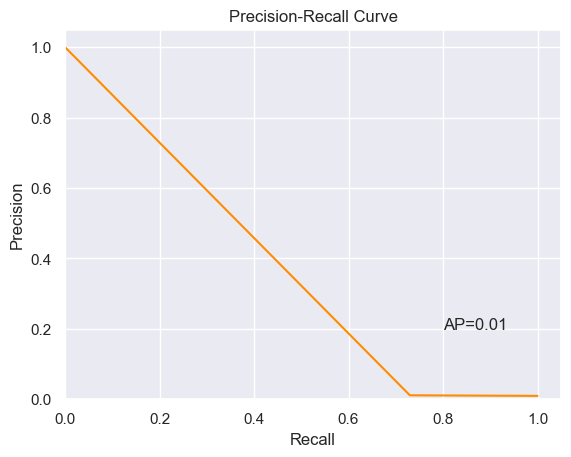

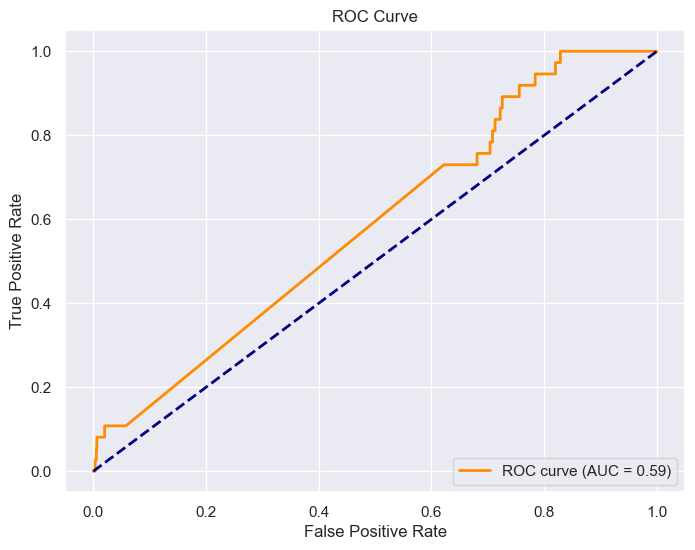

In [84]:
pre_y = model.predict(testX)
predict_y = np.copy(pre_y)
ymean=np.median(pre_y)
pre_y[pre_y<ymean]=0
pre_y[pre_y>=ymean]=1
met_classi(testY,pre_y)
plot_roc_curve(testY,predict_y)